<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Data_Sprint_35_Osteoarthritis_Knee_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

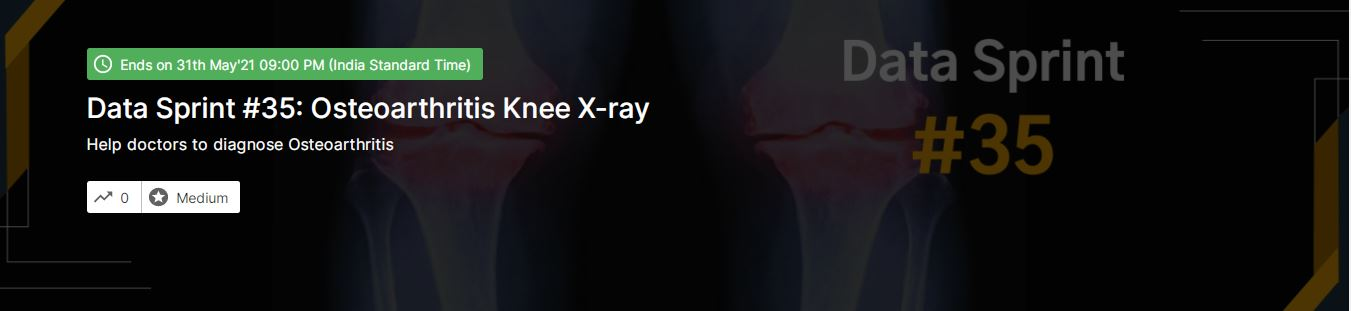

## Problem Statement
What is Knee osteoarthritis?

 

Knee osteoarthritis (OA), also known as degenerative joint disease, is typically the result of wear and tear and progressive loss of articular cartilage.

 

Difficult to understand the above medical terms, right? Let's understand what does osteoarthritis in the knee feel like:

 

If you have osteoarthritis of the knee, you will probably feel your knee is painful and stiff at times. It may only affect one knee, especially if you've injured it in the past, or you could have it in both. The pain may feel worse at the end of the day, or when you move your knee, and it may improve when you rest.

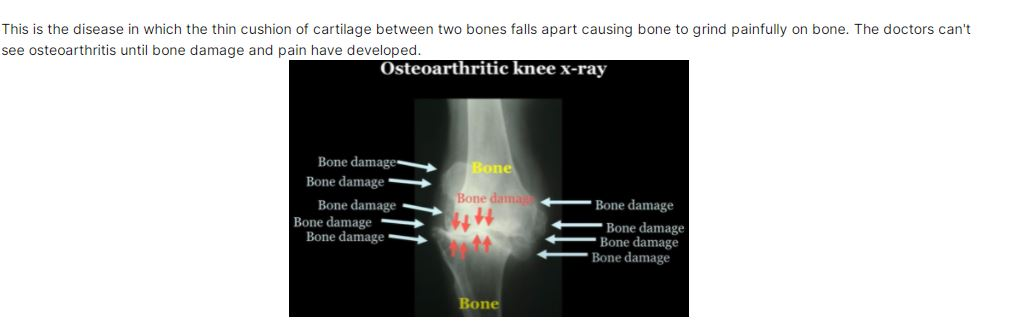

## About the data
This dataset contains knee X-ray data for both knee joint detection and knee KL grading. The Grade descriptions are as follows:

* Grade 0: Healthy knee image.

* Grade 1 (Doubtful): Doubtful joint narrowing with possible osteophytic lipping

* Grade 2 (Minimal): Definite presence of osteophytes and possible joint space narrowing

* Grade 3 (Moderate): Multiple osteophytes, definite joint space narrowing, with mild sclerosis.

* Grade 4 (Severe): Large osteophytes, significant joint narrowing, and severe sclerosis.

 

## Objective
Build a machine learning model to help doctors to diagnose Osteoarthritis.

## Evaluation
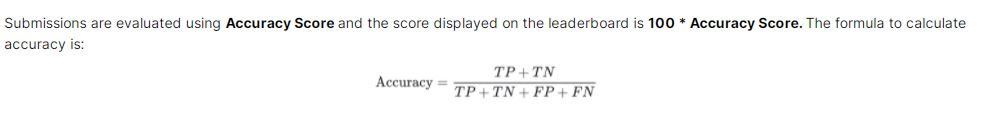

## Download the images

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC',
                                    dest_path='content/KneeXray.zip',
                                    unzip=True)

Unzipping...Done.


## Loading Libraries

In [3]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score,accuracy_score
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.exposure
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
train_data = pd.read_csv("/content/content/KneeXray/Train.csv")
test_data = pd.read_csv("/content/content/KneeXray/Test.csv")

In [ ]:
train_data.head()

,filename,label
0,Image_1.jpg,0
1,Image_2.jpg,1
2,Image_3.jpg,0
3,Image_4.jpg,1
4,Image_5.jpg,2


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7828 entries, 0 to 7827
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7828 non-null   object
 1   label     7828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 122.4+ KB


In [ ]:
label_dict = {0:"Healthy knee",
              1: "Doubtful",
              2 : "Minimal",
              3 : "Moderate",
              4 :"Severe"}

In [ ]:
label_dict

{0: 'Healthy knee', 1: 'Doubtful', 2: 'Minimal', 3: 'Moderate', 4: 'Severe'}

In [ ]:
train_data['label'] = train_data['label'].map(label_dict)

In [ ]:
train_data.head()

,filename,label
0,Image_1.jpg,Healthy knee
1,Image_2.jpg,Doubtful
2,Image_3.jpg,Healthy knee
3,Image_4.jpg,Doubtful
4,Image_5.jpg,Minimal


In [ ]:
print(f'total training samples {len(train_data)}')
print(f'total test samples {len(test_data)}')

total training samples 7828
total test samples 1958


## See the distribution of the image classes

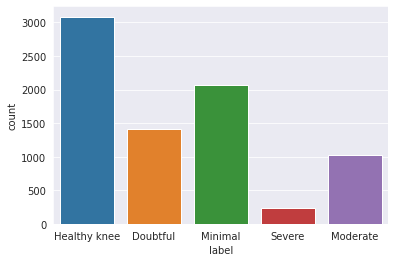

In [ ]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=train_data)

## Read a sample image and find out the shape of the images

In [ ]:
image = cv2.imread("/content/content/KneeXray/train/Image_5.jpg")
print(image.shape)

(224, 224, 3)


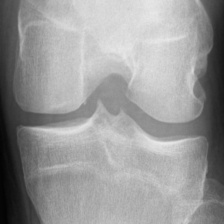

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [ ]:
base_dir = "/content/content/KneeXray"
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
train_dir

'/content/content/KneeXray/train'

#Create Separate Img Folders

In [ ]:
!mkdir "/content/content/KneeXray/train/Healthy knee"
!mkdir "/content/content/KneeXray/train/Doubtful"
!mkdir "/content/content/KneeXray/train/Minimal"
!mkdir "/content/content/KneeXray/train/Moderate"
!mkdir "/content/content/KneeXray/train/Severe"


In [ ]:
import shutil
img_items = train_data['filename'].values.tolist()
labels = train_data['label'].values.tolist()
for i in range(len(img_items)):
  image_path = "/content/content/KneeXray/train/"+ img_items[i]
  dest = train_dir + "/" + labels[i]
  shutil.move(image_path,dest)
  

In [ ]:
train_data['filename'] = train_data['label'] +"/" + train_data['filename']
train_data.head()

,filename,label
0,Healthy knee/Image_1.jpg,Healthy knee
1,Doubtful/Image_2.jpg,Doubtful
2,Healthy knee/Image_3.jpg,Healthy knee
3,Doubtful/Image_4.jpg,Doubtful
4,Minimal/Image_5.jpg,Minimal


## Split the nsamples into training and validation set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train_data,test_size=0.2,stratify=train_data['label'],shuffle=True)
print(f"len of training set {len(X_train)}")
print(f"len of validation set {len(X_valid)}")

len of training set 6262
len of validation set 1566


##  Plot some sample train images from each of the classes

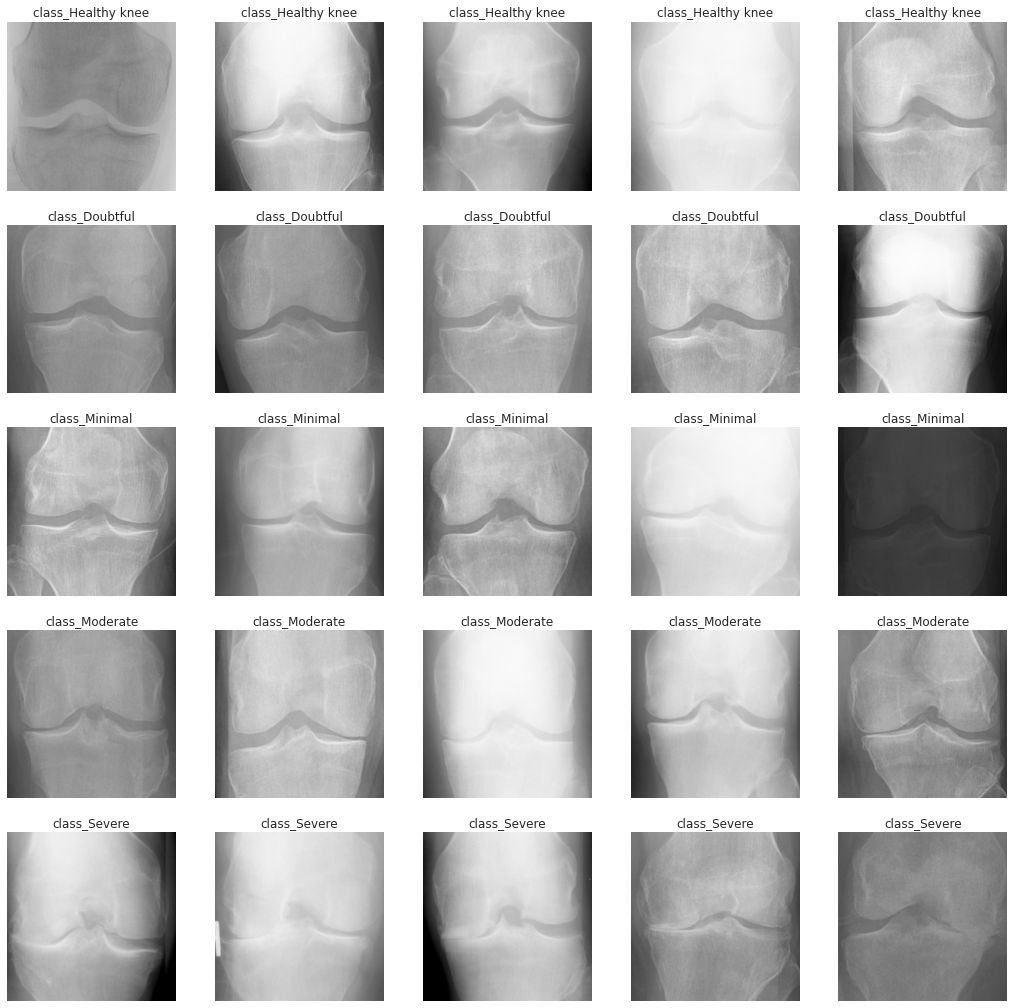

In [ ]:
import random
fig, ax = plt.subplots(5,5, figsize=(18,18))

for item in range(5):
  image_list = train_data[train_data['label'] ==label_dict[item]]['filename'].values.tolist()
  class_id = label_dict[item]
  sample = [train_dir+"/"+img for img in image_list]
  samples = random.sample(sample, 5)
  for col in range(5):
    image = cv2.imread(samples[col])
    ax[item, col].imshow(image)
    ax[item, col].set_title("class_" + str(class_id))
    ax[item, col].set_axis_off()
    
plt.show()

## Preprocess Image

In [ ]:
def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    #out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    return out1

## Data Augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(256, 256),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)


## Create Validation Directory

In [ ]:
!mkdir "/content/content/KneeXray/val/Healthy knee"
!mkdir "/content/content/KneeXray/val/Doubtful"
!mkdir "/content/content/KneeXray/val/Minimal"
!mkdir "/content/content/KneeXray/val/Moderate"
!mkdir "/content/content/KneeXray/val/Severe"

In [ ]:
X_valid.head()

,filename,label
6982,Healthy knee/Image_6983.jpg,Healthy knee
1235,Minimal/Image_1236.jpg,Minimal
895,Healthy knee/Image_896.jpg,Healthy knee
4883,Healthy knee/Image_4884.jpg,Healthy knee
118,Minimal/Image_119.jpg,Minimal


In [ ]:
val_dir

'/content/content/KneeXray/val'

In [ ]:
img_items = X_valid['filename'].values.tolist()
labels = X_valid['label'].values.tolist()
for i in range(len(img_items)):
  image_path = "/content/content/KneeXray/train/"+ img_items[i]
  dest = val_dir + "/" + labels[i]
  shutil.move(image_path,dest)

## Dealing with imbalanced datasets - determine class weights 

In [ ]:
from collections import Counter

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_dir)

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print("\nThe class weights are : \n\n", class_weights)

Found 6262 images belonging to 5 classes.

The class weights are : 

 {0: 2.17828773168579, 1: 1.0, 2: 1.4966646452395391, 3: 2.9987849331713243, 4: 13.058201058201059}


In [ ]:
train_generator.class_indices

{'Doubtful': 0, 'Healthy knee': 1, 'Minimal': 2, 'Moderate': 3, 'Severe': 4}

##Automatic Split of folders into train and validation sets

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
main_dir = '/content/content/KneeXray/train'
output_dir = '/content/content/KneeXray/train_val_split'

splitfolders.ratio(main_dir, output=output_dir, seed=1337, ratio=(.8, .2))

Copying files: 7828 files [00:00, 8528.32 files/s]


In [ ]:
NUM_CLASSES = 5
IMAGE_SIZE=[224, 224]
BATCH_SIZE=32
# Create the Generators
generator = ImageDataGenerator(        rescale=1./255,
                                        #preprocessing_function=preprocess,
                                        preprocessing_function=data_augment, 
                                        samplewise_center = True,
                                        samplewise_std_normalization = True,   
                                        #rotation_range=10,
                                        #width_shift_range=0.2,
                                        #height_shift_range=0.2,
                                        #shear_range=0.1,
                                        #zoom_range=0.2,
                                        #horizontal_flip=True,
                                        #vertical_flip=False,
                                        #fill_mode='nearest'
                                        )


# Train data generator
train_datagenerator = generator.flow_from_dataframe(
dataframe=X_train,
directory="/content/content/KneeXray/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 6262 validated image filenames belonging to 5 classes.


In [ ]:
# Validation data generator
valid_datagenerator = generator.flow_from_dataframe(
dataframe=X_valid,
directory="/content/content/KneeXray/val",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 1566 validated image filenames belonging to 5 classes.


In [ ]:
# Test data generator
test_generator  = ImageDataGenerator(rescale=1./255,
                                     #preprocessing_function=preprocess
                                     preprocessing_function=data_augment)
test_data = test_generator.flow_from_directory("/content/content/KneeXray" ,
                                               classes=['test'],
                                               target_size=(224,224),
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 1958 images belonging to 1 classes.


In [ ]:
train_datagenerator.class_indices

{'Doubtful': 0, 'Healthy knee': 1, 'Minimal': 2, 'Moderate': 3, 'Severe': 4}

In [ ]:
valid_datagenerator.class_indices

{'Doubtful': 0, 'Healthy knee': 1, 'Minimal': 2, 'Moderate': 3, 'Severe': 4}

## Train Datagenerator Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
(224, 224, 3)


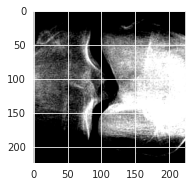

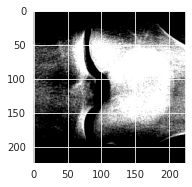

In [ ]:
x,y = train_datagenerator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

### Validation  Datagenerator Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
(224, 224, 3)


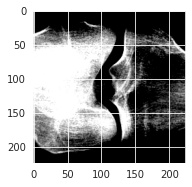

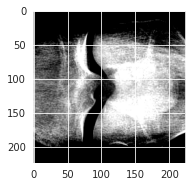

In [ ]:
x,y = valid_datagenerator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

## Import Keras libraries

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50,ResNet152
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,DenseNet121,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile,DenseNet169
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def build_model():
  model = Sequential()

  conv_base = DenseNet121(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(5, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model

In [ ]:
my_model=build_model()

In [ ]:
resnet= ResNet152(weights="imagenet",)
x=resnet.layers[-2].output
fc1=Dense(5,activation='softmax',kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005))(x)
my_model=Model(inputs=resnet.input,outputs=fc1)

242900992/242900224 [==============================] - 3s 0us/step


In [ ]:
my_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_datagenerator.n//valid_datagenerator.batch_size

In [ ]:
STEP_SIZE_TRAIN,STEP_SIZE_VALID

(195, 48)

## Evaluation Metrics

In [ ]:
import keras.backend as K

def f1(y_true, y_pred): #taken from old keras source code
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [ ]:
my_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=[f1,'accuracy'],
                 loss= tf.keras.losses.CategoricalCrossentropy())

In [ ]:
!mkdir "/content/training_0"

## Callbacks

In [ ]:
checkpoint_path = "training_0/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path, monitor = 'val_f1',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
               EarlyStopping(monitor='val_f1', patience=10, verbose=0, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [ ]:
history = my_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=20,
        validation_data=valid_datagenerator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks],
        class_weight={0: 2.17828773168579, 1: 1.0, 2: 1.4966646452395391, 3: 2.9987849331713243, 4: 13.058201058201059})

Epoch 1/20
195/195 [==============================] - 145s 643ms/step - loss: 3.0546 - f1: 0.0536 - accuracy: 0.3013 - val_loss: 2.3691 - val_f1: 0.0464 - val_accuracy: 0.2650

Epoch 00001: val_f1 improved from -inf to 0.04635, saving model to training_0/cp.ckpt
Epoch 2/20
195/195 [==============================] - 121s 621ms/step - loss: 1.6800 - f1: 0.4003 - accuracy: 0.5763 - val_loss: 4.4689 - val_f1: 0.1837 - val_accuracy: 0.1836

Epoch 00002: val_f1 improved from 0.04635 to 0.18367, saving model to training_0/cp.ckpt
Epoch 3/20
195/195 [==============================] - 121s 622ms/step - loss: 1.0989 - f1: 0.6879 - accuracy: 0.7639 - val_loss: 4.4312 - val_f1: 0.0299 - val_accuracy: 0.0299

Epoch 00003: val_f1 did not improve from 0.18367
Epoch 4/20
195/195 [==============================] - 121s 621ms/step - loss: 0.7323 - f1: 0.8398 - accuracy: 0.8782 - val_loss: 2.5921 - val_f1: 0.1735 - val_accuracy: 0.1784

Epoch 00004: val_f1 did not improve from 0.18367
Epoch 5/20
195/195 

## Vision Transformer Model 

In [ ]:
%%capture
!pip install tensorflow_addons

In [ ]:
%%capture
!pip install vit-keras

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow_addons as tfa
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [ ]:
labels = os.listdir("/content/content/KneeXray/train")
labels 

['Moderate', 'Severe', 'Doubtful', 'Minimal', 'Healthy knee']

## Setting Parameters

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 20

## Setting Path Variables

In [ ]:
TRAIN_PATH = '/content/content/KneeXray/train'
VALID_PATH = '/content/content/KneeXray/val'
TEST_PATH = '/content/content/KneeXray/test'


## Data Augmentation

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Data Generator

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

In [ ]:
train_gen = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    class_mode="categorical",
    seed=42
)

Found 6262 images belonging to 5 classes.


In [ ]:
valid_gen = datagen.flow_from_directory(
    directory = VALID_PATH,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    class_mode="categorical",
    seed=42
)

Found 1566 images belonging to 5 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
        "/content/content/KneeXray/",
        classes=['test'],
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 1958 images belonging to 1 classes.


## Train Datagenerator visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)


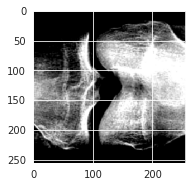

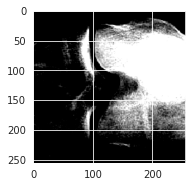

In [ ]:
x,y = train_gen.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

## Validation Datagenerator Visualization 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)


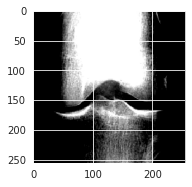

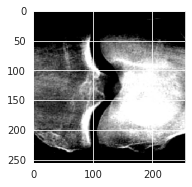

In [ ]:
x,y = valid_gen.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

## Test Datgenartor Visualization

(256, 256, 3)


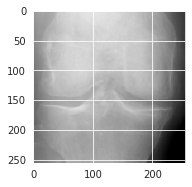

In [ ]:
x,_ = test_gen.next()
for i in range(1):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

## Visualize Traing Data Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

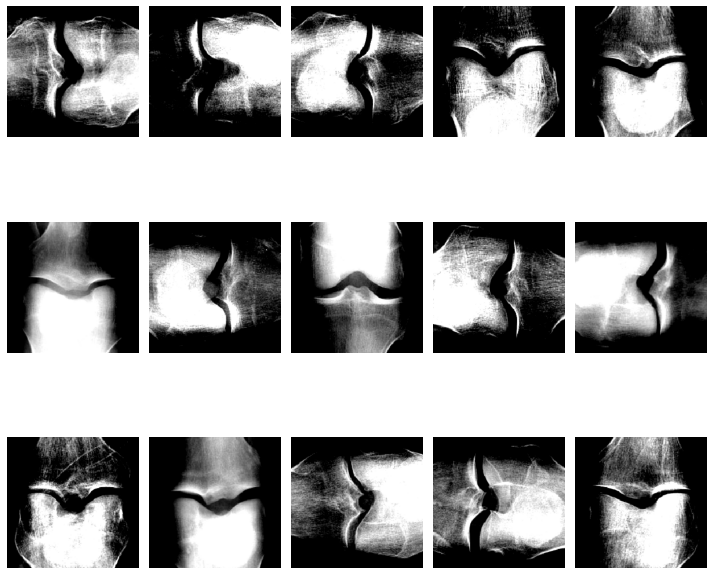

In [ ]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Build Model

In [ ]:
from vit_keras import vit

#ViT B32 Model

In [ ]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = len(labels))

353255424/353253686 [==============================] - 4s 0us/step


## Fine-tuning the Model

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(len(labels), 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87466752  
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_224 (Bat (None, 768)               3072      
_________________________________________________________________
dense_8 (Dense)              (None, 11)                8459      
_________________________________________________________________
batch_normalization_225 (Bat (None, 11)                44        
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 60        
Total params: 87,478,387
Trainable params: 87,476,829
Non-trainable params: 1,558
________________________________

## Setting Model Hyperparameters and Callbacks

In [ ]:
import keras.backend as K

def f1(y_true, y_pred): #taken from old keras source code
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [ ]:
learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy',f1])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]


## Training the Model

In [ ]:
model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

Epoch 1/20
391/391 [==============================] - 141s 360ms/step - loss: 1.1790 - accuracy: 0.6527 - f1: 0.5550 - val_loss: 1.2610 - val_accuracy: 0.5883 - val_f1: 0.5319

Epoch 00001: val_accuracy did not improve from 0.61534
Epoch 2/20
391/391 [==============================] - 141s 360ms/step - loss: 1.1619 - accuracy: 0.6598 - f1: 0.5841 - val_loss: 1.2312 - val_accuracy: 0.5986 - val_f1: 0.5468

Epoch 00002: val_accuracy did not improve from 0.61534
Epoch 3/20
391/391 [==============================] - 141s 360ms/step - loss: 1.1579 - accuracy: 0.6662 - f1: 0.5884 - val_loss: 1.2294 - val_accuracy: 0.6057 - val_f1: 0.5570

Epoch 00003: val_accuracy did not improve from 0.61534
Epoch 4/20
391/391 [==============================] - 140s 358ms/step - loss: 1.1438 - accuracy: 0.6708 - f1: 0.5973 - val_loss: 1.2295 - val_accuracy: 0.6128 - val_f1: 0.5738

Epoch 00004: val_accuracy did not improve from 0.61534
Epoch 5/20
391/391 [==============================] - 140s 357ms/step - 

## Applying Class Weights 

In [ ]:
model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks,class_weight={0: 2.17828773168579, 1: 1.0, 2: 1.4966646452395391, 3: 2.9987849331713243, 4: 13.058201058201059})

Epoch 1/20
391/391 [==============================] - 151s 361ms/step - loss: 2.1211 - accuracy: 0.6888 - f1: 0.6152 - val_loss: 1.2062 - val_accuracy: 0.6282 - val_f1: 0.5691

Epoch 00001: val_accuracy did not improve from 0.63080
Epoch 2/20
391/391 [==============================] - 141s 360ms/step - loss: 2.0909 - accuracy: 0.6956 - f1: 0.6176 - val_loss: 1.2146 - val_accuracy: 0.6211 - val_f1: 0.5793

Epoch 00002: val_accuracy did not improve from 0.63080
Epoch 3/20
391/391 [==============================] - 140s 359ms/step - loss: 2.0845 - accuracy: 0.6982 - f1: 0.6138 - val_loss: 1.2107 - val_accuracy: 0.6256 - val_f1: 0.5825

Epoch 00003: val_accuracy did not improve from 0.63080
Epoch 4/20
391/391 [==============================] - 140s 359ms/step - loss: 2.0688 - accuracy: 0.6984 - f1: 0.6185 - val_loss: 1.2243 - val_accuracy: 0.6031 - val_f1: 0.5653

Epoch 00004: val_accuracy did not improve from 0.63080
Epoch 5/20
391/391 [==============================] - 140s 359ms/step - 

## Training Accuracy Vs Validation Accuracy

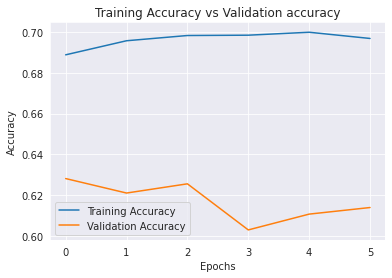

In [ ]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()+

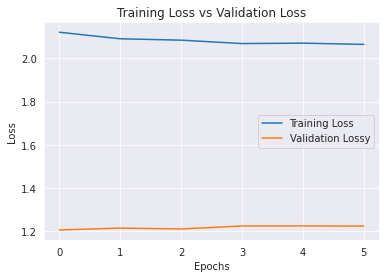

In [ ]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Lossy')
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
loss,accuracy,f1_score = model.evaluate(valid_gen)

98/98 [==============================] - 22s 221ms/step - loss: 1.2039 - accuracy: 0.6226 - f1: 0.5778


## Make Predictions on test data

In [ ]:
preds = model.predict(test_gen)

In [ ]:
predictions = [np.argmax(x) for x in preds]

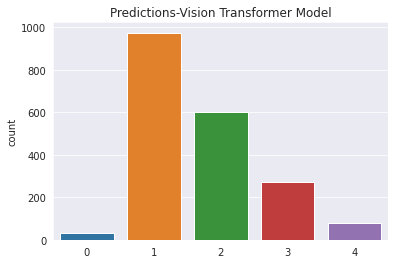

In [ ]:
sns.set_style('darkgrid')
sns.countplot(predictions)
plt.title('Predictions-Vision Transformer Model')
plt.show()

In [ ]:
valid_gen.class_indices

{'Doubtful': 0, 'Healthy knee': 1, 'Minimal': 2, 'Moderate': 3, 'Severe': 4}

In [ ]:
reverse_labels = {0 : 'Doubtful',1:'Healthy knee',2:'Minimal',3:'Moderate',4:'Severe'}
reverse_labels

{0: 'Doubtful', 1: 'Healthy knee', 2: 'Minimal', 3: 'Moderate', 4: 'Severe'}

In [ ]:
predicted_labels = [reverse_labels[pred] for pred in predictions ]

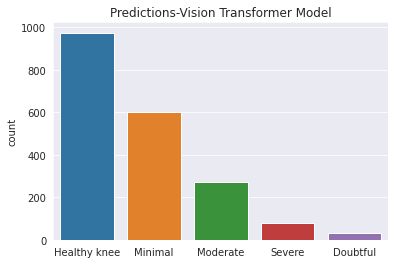

In [ ]:
sns.countplot(predicted_labels)
plt.title('Predictions-Vision Transformer Model')
plt.show()

In [ ]:
label_dict

{0: 'Healthy knee', 1: 'Doubtful', 2: 'Minimal', 3: 'Moderate', 4: 'Severe'}

In [ ]:
reverse_actual_labels = {v: k for k,v in label_dict.items()}
reverse_actual_labels

{'Doubtful': 1, 'Healthy knee': 0, 'Minimal': 2, 'Moderate': 3, 'Severe': 4}

In [ ]:
sub = pd.read_csv("/content/content/KneeXray/sample_submission.csv")
sub.head()

,filename,label
0,Image_1.jpg,0
1,Image_2.jpg,0
2,Image_3.jpg,0
3,Image_4.jpg,0
4,Image_5.jpg,0


In [ ]:
test_df = pd.read_csv("/content/content/KneeXray/Test.csv")
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
test_df['label'] = predicted_labels
#test_df['label'] = predictions
test_df.head()

,filename,label
0,Image_1.jpg,Healthy knee
1,Image_2.jpg,Healthy knee
2,Image_3.jpg,Minimal
3,Image_4.jpg,Healthy knee
4,Image_5.jpg,Minimal


In [ ]:
test_df['label'] = test_df['label'].apply(lambda x :reverse_actual_labels[x] )
test_df.head()

,filename,label
0,Image_1.jpg,0
1,Image_2.jpg,0
2,Image_3.jpg,2
3,Image_4.jpg,0
4,Image_5.jpg,2


In [ ]:
test_df.to_csv("Vision_transformer.csv",index=False)

**Submission successful! Your score is 30.439223697650664.**

## FastAi

In [2]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
#from fastai.callbacks.hooks import *
from fastai.callbacks import *
#
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
#
import warnings
warnings.filterwarnings('ignore')

In [4]:
path ='/content/content/KneeXray/train/'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '/content/content/KneeXray/Train.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/content/KneeXray/test')              
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

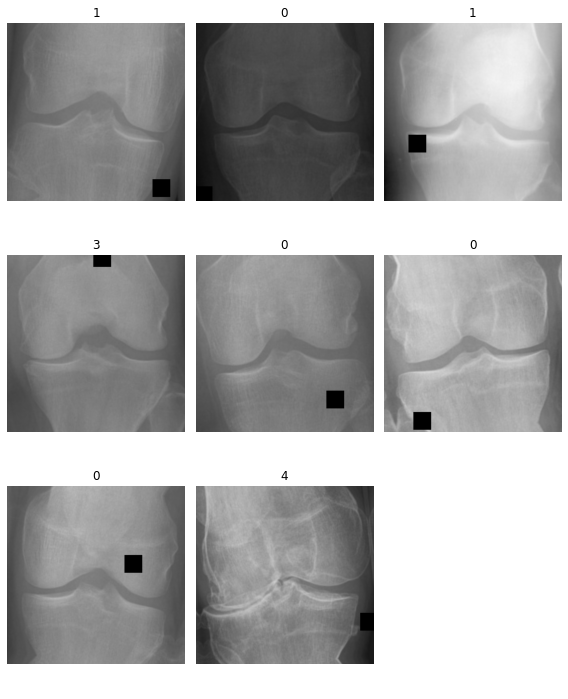

In [5]:
data.show_batch(rows=3, figsize=(8,10))

In [6]:
## print the target classes
val=data.classes
print(f"The number of target class : {data.c} and the respective target classes are a: {data.classes}")

The number of target class : 5 and the respective target classes are a: [0, 1, 2, 3, 4]


In [7]:
data

ImageDataBunch;

Train: LabelList (6263 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
0,1,1,2,2
Path: /content/content/KneeXray/train;

Valid: LabelList (1565 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
3,1,0,0,0
Path: /content/content/KneeXray/train;

Test: LabelList (1958 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: EmptyLabelList
,,,,
Path: /content/content/KneeXray/train

## Define F1 metrics

* When we care more about minimizing false positives than minimizing false negatives, we would want to select a beta value of < 1 for the F-beta score. precision would be given more weight than recall in this scenario

* When the priority is to minimize false negatives, we would want to select a beta value of >1 for the F-beta score. Recall would be considered more important than precision in this scenario.

In [8]:
fscore = FBeta(average='macro', beta=2.0)

In [ ]:
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, accuracy,fscore])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.638307,1.426829,0.611502,0.388498,0.322604,03:41
1,1.230294,1.023203,0.463898,0.536102,0.461674,03:38
2,1.059900,0.922190,0.399361,0.600639,0.534398,03:38


In [ ]:
learn2 = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy,fscore])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
learn2.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.561828,1.297468,0.548882,0.451118,0.346524,05:40
1,1.155938,0.930856,0.388498,0.611502,0.557108,05:39
2,1.017444,0.856203,0.361022,0.638978,0.601190,05:38


##Set the Path

In [9]:
path= '/content/content/KneeXray/'
k= '/content/content/KneeXray/Train.csv'
p ='/content/content/KneeXray/Test.csv'
#
train=pd.read_csv(k)
test=pd.read_csv(p)

In [10]:
np.random.seed(1786)
ROOT = "/content/content/KneeXray/"

In [11]:
def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

##Define Callback

In [12]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc,f1 = metrics[0], metrics[1],metrics[2]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.best_f1 = f1
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
            print("Save the best f1 {:.5f}".format(self.best_f1))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

## Perform Training Validation and Evaluation using Densenet121 model with Cross_Validation

(7828, 2) (1958, 1)
Starting fold 0
(7338,) (490,)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.911512,1.624415,0.614286,0.385714,0.324006,01:12
1,1.311386,1.208795,0.489796,0.510204,0.394929,01:09
2,1.131079,1.020421,0.432653,0.567347,0.506781,01:09
3,1.007452,0.982237,0.406122,0.593878,0.500081,01:09
4,0.953647,0.947398,0.404082,0.595918,0.489003,01:09


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.917474,0.904476,0.393878,0.606122,0.568564,01:23
1,0.907363,0.948411,0.385714,0.614286,0.563967,01:23
2,0.892889,0.843420,0.359184,0.640816,0.623924,01:23
3,0.846480,0.793752,0.336735,0.663265,0.619796,01:23
4,0.833936,0.761267,0.340816,0.659184,0.667517,01:23
5,0.765959,0.747390,0.314286,0.685714,0.691900,01:24
6,0.690464,0.729571,0.318367,0.681633,0.694738,01:23
7,0.639300,0.712352,0.291837,0.708163,0.703055,01:23
8,0.588186,0.721574,0.304082,0.695918,0.706466,01:23
9,0.554128,0.707214,0.293878,0.706122,0.709237,01:23


Better model found at epoch 0 with error_rate value: 0.3938775658607483.


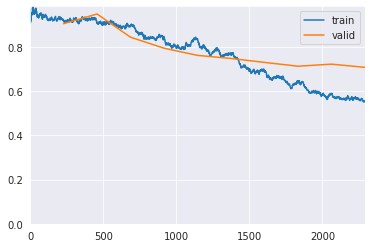

Better model found at epoch 1 with error_rate value: 0.3857142925262451.
Better model found at epoch 2 with error_rate value: 0.359183669090271.
Better model found at epoch 3 with error_rate value: 0.33673468232154846.
Better model found at epoch 5 with error_rate value: 0.3142857253551483.
Better model found at epoch 7 with error_rate value: 0.2918367385864258.


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.602621,0.714852,0.300000,0.700000,0.706786,01:23
1,0.601782,0.735878,0.310204,0.689796,0.689962,01:23
2,0.620079,0.714493,0.291837,0.708163,0.735679,01:23
3,0.560167,0.734127,0.308163,0.691837,0.665771,01:23
4,0.533683,0.744966,0.295918,0.704082,0.698890,01:23
5,0.518050,0.804340,0.338776,0.661224,0.674840,01:23
6,0.426922,0.779465,0.285714,0.714286,0.713077,01:23
7,0.374272,0.808659,0.312245,0.687755,0.694376,01:23


Better model found at epoch 0 with error_rate value: 0.30000001192092896.


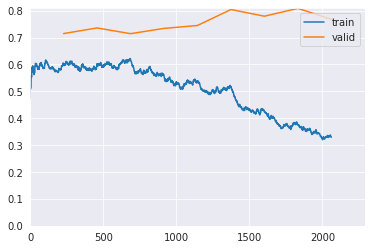

Better model found at epoch 2 with error_rate value: 0.2918367385864258.
Better model found at epoch 6 with error_rate value: 0.2857142984867096.
Epoch 8: early stopping


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.349955,0.769079,0.322449,0.677551,0.676137,01:24
1,0.344011,0.814309,0.334694,0.665306,0.690157,01:23
2,0.324392,0.803973,0.324490,0.675510,0.690695,01:23
3,0.316092,0.793262,0.320408,0.679592,0.691806,01:23
4,0.292183,0.792518,0.320408,0.679592,0.692412,01:23


Better model found at epoch 0 with error_rate value: 0.3224489688873291.


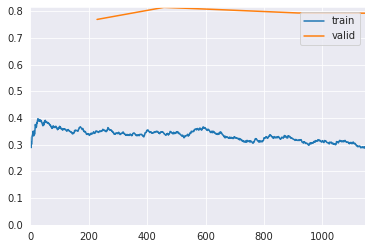

Better model found at epoch 3 with error_rate value: 0.3204081654548645.


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.291420,0.792990,0.318367,0.681633,0.693919,01:23
1,0.291303,0.814713,0.322449,0.677551,0.691634,01:23
2,0.280841,0.813084,0.324490,0.675510,0.686408,01:23
3,0.284406,0.814719,0.322449,0.677551,0.690622,01:23
4,0.296185,0.819348,0.332653,0.667347,0.685490,01:23
5,0.281325,0.823108,0.322449,0.677551,0.689742,01:23


Better model found at epoch 0 with error_rate value: 0.3183673322200775.


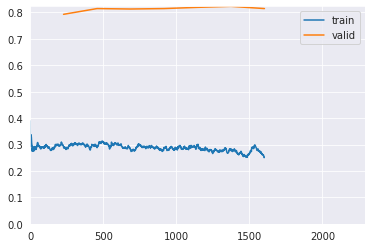

Epoch 6: early stopping


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.289306,0.804693,0.320408,0.679592,0.696402,01:23
1,0.287457,0.794406,0.314286,0.685714,0.697210,01:23
2,0.294723,0.806151,0.322449,0.677551,0.693008,01:24
3,0.290114,0.805567,0.326531,0.673469,0.688837,01:23
4,0.288217,0.810791,0.326531,0.673469,0.689220,01:23
5,0.277996,0.798116,0.320408,0.679592,0.693062,01:24
6,0.286280,0.799714,0.324490,0.675510,0.688397,01:24


Better model found at epoch 0 with error_rate value: 0.3204081654548645.


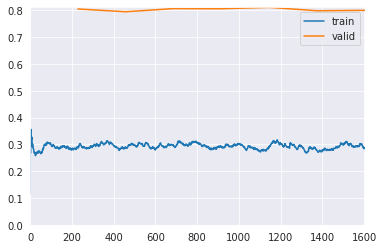

Better model found at epoch 1 with error_rate value: 0.3142857253551483.


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.904142,1.041070,0.434694,0.565306,0.480818,01:24
1,0.992897,1.015632,0.402041,0.597959,0.596098,01:24
2,0.972088,0.899565,0.338776,0.661224,0.616772,01:24
3,0.859030,0.762903,0.340816,0.659184,0.625238,01:25
4,0.771503,0.699842,0.308163,0.691837,0.668958,01:24


Better model found at epoch 0 with error_rate value: 0.4346938729286194.


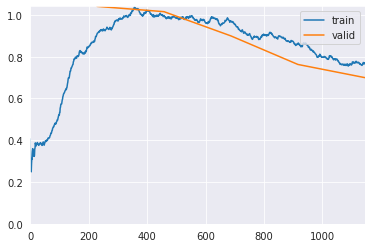

Better model found at epoch 1 with error_rate value: 0.4020408093929291.
Better model found at epoch 2 with error_rate value: 0.33877551555633545.
Better model found at epoch 4 with error_rate value: 0.30816325545310974.


F1 score for this fold  0.6124092989327519


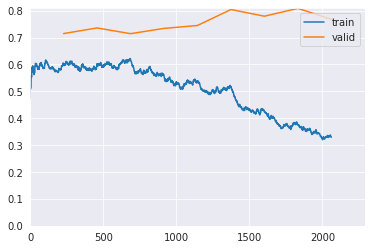

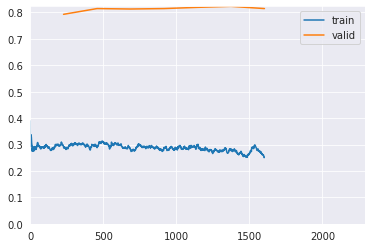

In [21]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(1):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT,folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        #learn = cnn_learner(data, models.densenet121, metrics=[error_rate,accuracy,fscore], ps=0.5)
        learn = cnn_learner(data, models.densenet201, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=5),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(5)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-3, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

In [22]:
test_preds

array([[1.276764, 1.299026, 1.613499, 1.014894, 1.000867],
       [1.742137, 1.31209 , 1.173053, 1.012755, 1.000982],
       [1.91788 , 1.300931, 1.076563, 1.011194, 1.000794],
       [2.090713, 1.187226, 1.087069, 1.006682, 1.000731],
       ...,
       [1.096224, 1.196875, 2.02796 , 1.021158, 1.000448],
       [2.462182, 1.082413, 1.017014, 1.002236, 1.000654],
       [1.069202, 1.157823, 1.792711, 1.221407, 1.002817],
       [1.939427, 1.243462, 1.09004 , 1.03329 , 1.000745]], dtype=float32)

In [15]:
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [23]:
sub = test[["filename"]]
sub["label"] = np.argmax(test_preds, axis=1)

In [24]:
sub.head()

,filename,label
0,Image_1.jpg,2
1,Image_2.jpg,0
2,Image_3.jpg,0
3,Image_4.jpg,0
4,Image_5.jpg,4


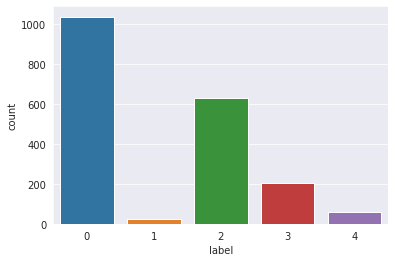

In [ ]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=sub)
plt.show()

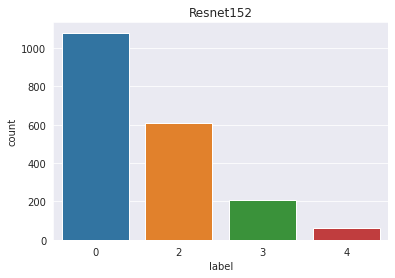

In [18]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=sub)
plt.title("Resnet152")
plt.show()

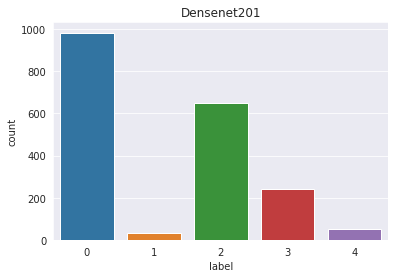

In [25]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=sub)
plt.title("Densenet201")
plt.show()

In [26]:
sub.to_csv("submission_densenet201.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_densenet201.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Fastai Densenet121 -Submission successful! Your score is 69.40755873340143.**

**Fastai Resnet152 -Submission successful! Your score is 66.13891726251276.**

**Fastai Densenet201 - Submission successful! Your score is 70.2247191011236.**